# Introduction


### Finding Tsync for Kuramoto model

First freeze parameter at (K,gamma) = (3,1), and then find R_final

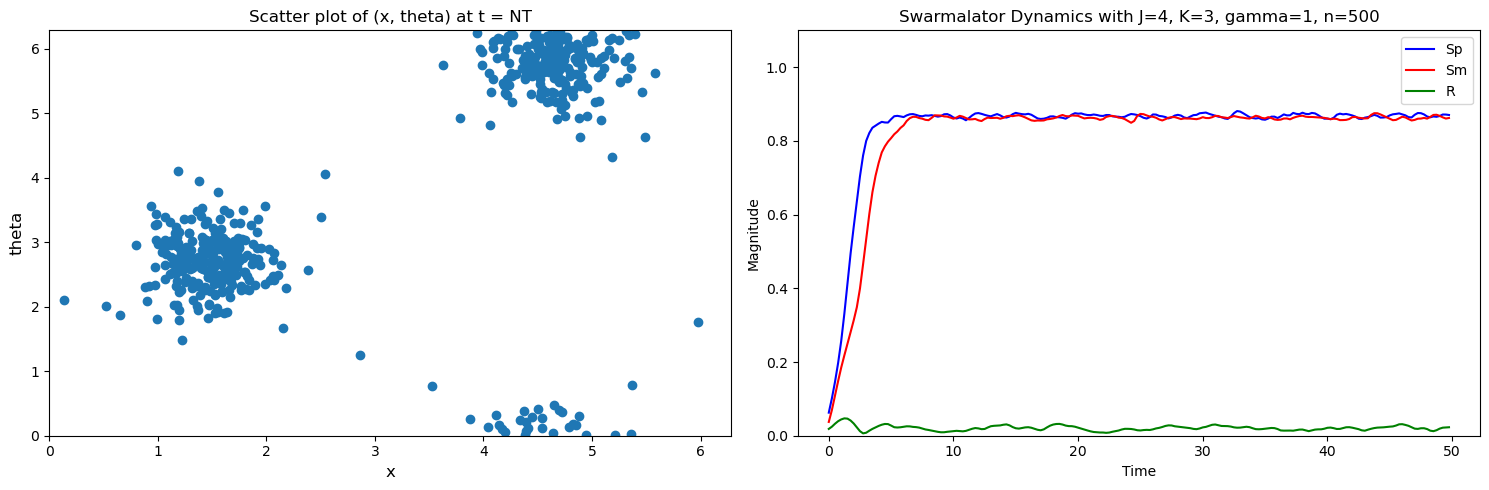

(0.8697384380184836, 0.8620124624229317)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

# Initial setups
dt, T, n = 0.25, 50, 500
J, K, mu, gamma = 4, 3, 0, 1  # sync
omega_dist = 'gaussian_random'
omega, nu = make_omega(mu, gamma,n, omega_dist=omega_dist), make_omega(mu, gamma,n,omega_dist=omega_dist) 
(x0,theta0) = np.random.uniform(0,2*np.pi,n), np.random.uniform(0,2*np.pi,n)
z0 = np.concatenate([x0, theta0])
(t,NT) = (0,int(T/dt))
args = (J,K,nu,omega)

# Simulation loop
z = z0
Ws = []
Zs = []
ts = []
for t in range(NT):
    Wp, Wm = find_rainbow_order_parameters(z)
    theta = z[n:]
    Z = find_sync_order_parameter(theta)
    Ws.append((Wp, Wm))
    Zs.append(Z)
    z = rk4(dt, z, rhs_swarmlator, args)
    ts.append(t * dt)
              
# Data extraction
Sp = [np.abs(wp) for wp, _ in Ws]
Sm = [np.abs(wm) for _, wm in Ws]
R = np.abs(Zs)
x_final, theta_final = np.mod(z[:n], 2*np.pi), np.mod(z[n:], 2*np.pi)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Left plot: Scatter plot of (x, theta) at t = NT
ax[0].scatter(x_final, theta_final)
ax[0].set_xlim([0, 2*np.pi])
ax[0].set_ylim([0, 2*np.pi])
ax[0].set_xlabel('x', fontsize=12)
ax[0].set_ylabel('theta', fontsize=12)
ax[0].set_title('Scatter plot of (x, theta) at t = NT')

# Right plot: Dynamics of Sp and Sm over time
ax[1].plot(ts, Sp, label="Sp", color="blue")
ax[1].plot(ts, Sm, label="Sm", color="red")
ax[1].plot(ts, R, label="R", color="green")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Magnitude')
ax[1].set_title(f"Swarmalator Dynamics with J={J}, K={K}, gamma={gamma}, n={n}")
ax[1].legend()
ax[1].set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

cutoff = int(0.9*len(Sp))
Sp_final = np.mean(np.abs(Sp[cutoff:]))
Sm_final = np.mean(np.abs(Sm[cutoff:]))

Sp_final, Sm_final


### Now use this to find the Tsync

In [27]:
import os
import time
from datetime import date

def simulate_T_sp_sm(eps, Sp_final, Sm_final, dt, T, n, J, K, mu, gamma, omega_dist):
    # Initial setups
    omega, nu = make_omega(mu, gamma, n, omega_dist=omega_dist), make_omega(mu, gamma, n, omega_dist=omega_dist)
    (x0, theta0) = np.random.uniform(0, 2*np.pi, n), np.random.uniform(0, 2*np.pi, n)
    z0 = np.concatenate([x0, theta0])
    (t, NT) = (0, int(T/dt))
    args = (J, K, nu, omega)
    
    # Simulation loop
    z = z0
    Ws = []
    ts = []
    for t in range(NT):
        Wp, Wm = find_rainbow_order_parameters(z)
        Sp_current = np.abs(Wp)
        Sm_current = np.abs(Wm)
        
        # Check if within epsilon of final value
        if abs(Sp_current - Sp_final) <= eps:
            T_sp = t * dt
            return T_sp, None
        elif abs(Sm_current - Sm_final) <= eps:
            T_sm = t * dt
            return None, T_sm
        
        z = rk4(dt, z, rhs_swarmlator, args)
        ts.append(t * dt)
        Ws.append((Wp, Wm))
    
    # Return None if the simulation did not converge within epsilon
    return None, None


# Pars
Sp_final, Sm_final = (0.8701996533786576, 0.8649254007529926)
eps = 0.01  # Choose your desired value for epsilon
N_trial = 10**3  # Or any other number of trials
T_sp_values = []
T_sm_values = []

# For logging
start_time = time.time()
total_time_for_trials = 0
for trial in range(N_trial):
    trial_start_time = time.time()
    T_sp, T_sm = simulate_T_sp_sm(eps, Sp_final, Sm_final, dt, T, n, J, K, mu, gamma, omega_dist)
    trial_end_time = time.time()
    trial_duration = trial_end_time - trial_start_time
    total_time_for_trials += trial_duration
    average_time_per_trial = total_time_for_trials / (trial + 1)
    estimated_time_left = average_time_per_trial * (N_trial - trial - 1)
    if T_sp is not None:
        T_sp_values.append(T_sp)
    if T_sm is not None:
        T_sm_values.append(T_sm)
    
    # Logging
    print(f"Trial {trial + 1}/{N_trial}")
    print(f"Time for current run: {trial_duration:.2f} seconds")
    print(f"Estimated time left: {estimated_time_left/60.0:.2f} min")
    print(f"Total estimated time: {(estimated_time_left + total_time_for_trials)/60.0:.2f} min")
    print("-------------------------")

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

# Save
dir_name = "data/"
os.makedirs(dir_name, exist_ok=True)
current_date = date.today().strftime('%Y-%m-%d')

# Save T_sp_values
fname_sp = f"{dir_name}{current_date}/Tsp_swarmlator_J{J}_K{K}_gamma{gamma}_n{n}_eps{eps}.npy"
os.makedirs(os.path.dirname(fname_sp), exist_ok=True)
np.save(fname_sp, T_sp_values)

# Save T_sm_values
fname_sm = f"{dir_name}{current_date}/Tsm_swarmlator_J{J}_K{K}_gamma{gamma}_n{n}_eps{eps}.npy"
os.makedirs(os.path.dirname(fname_sm), exist_ok=True)
np.save(fname_sm, T_sm_values)

# Plot
plt.figure(figsize=(10, 6))
plt.hist(T_sp_values, bins=20, alpha=0.6, edgecolor='k', label='T_sp(eps)')
plt.hist(T_sm_values, bins=20, alpha=0.6, edgecolor='k', label='T_sm(eps)')
plt.xlabel('Time')
plt.ylabel('Number of Trials')
plt.title('Distribution of T_sp and T_sm Times')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

Trial 1/1000
Time for current run: 0.59 seconds
Estimated time left: 9.86 min
Total estimated time: 9.87 min
-------------------------
Trial 2/1000
Time for current run: 0.69 seconds
Estimated time left: 10.69 min
Total estimated time: 10.71 min
-------------------------
Trial 3/1000
Time for current run: 0.64 seconds
Estimated time left: 10.68 min
Total estimated time: 10.71 min
-------------------------
Trial 4/1000
Time for current run: 0.76 seconds
Estimated time left: 11.15 min
Total estimated time: 11.19 min
-------------------------
Trial 5/1000
Time for current run: 2.37 seconds
Estimated time left: 16.76 min
Total estimated time: 16.84 min
-------------------------
Trial 6/1000
Time for current run: 0.55 seconds
Estimated time left: 15.48 min
Total estimated time: 15.57 min
-------------------------
Trial 7/1000
Time for current run: 0.77 seconds
Estimated time left: 15.08 min
Total estimated time: 15.18 min
-------------------------
Trial 8/1000
Time for current run: 0.66 sec